#Video Game Sales with Ratings
*Cas kaggle*

Gerard Benet Martínez - 1704125
Javier Emparan López - 1704634

---

## Definició del problema

Aquest projecte se centra en l'anàlisi predictiva de les ventes de videojocs, utilitzant una base de dades que integra una àmplia col·lecció de títols amb les seves mètriques de qualitat extretes principalment de la plataforma Metacritic. A partir d'aquesta, l'objectiu és crear un regressor capaç de predir les ventes d'un joc tant a nivell global com per a les diferents regions. Per aconseguir això, hem de desenvolupar un model que pugui generalitzar les diferents tendències i les característques que causen que un joc vengui bé en cada una d'aquestes. En aquest cas kaggle:

- S'analitzaran les dades i es realitzarà un preprocessat d'aquestes per a potenciar el futur entrenament del model. En aquest preprocessament, s'eliminaràn els nans presents a la base de dades, s'escalaràn els atributs amb un escalador que es seleccionarà prèviament i es realitzarà un encoding de variables categòriques.
- S'entrenarà un regressor del tipus XGB amb les dades obtingudes del preprocessament. Aquest procés és realitzarà mitjançant pipelines per evitar el data leakage i aconseguir que els resultats siguin el més realistes possibles. També s'utilitzarà una GridSearch per a provar diferents combinacions d'hiperparàmetres possibles.
- Es validaràn els resultats del model mitjançant validació creuada i s'analitzarà el seu rendiment final.

Cal destacar que s'han provat bastants altres tipus de models, l'ús de regularitzadors per a models lineals i altres mètriques de validació entre altres coses.
Això ho explicarem amb més detall en cada un dels apartats, però es pot apreciar amb més profunditat en diferents punts del git. Per exemple, en una branca alternativa hem provat a fer funcionar models lineals, o en versions anteriors d'aquesta hem utilitzat altres tipus de models no lineals.

---

A continuació tenim l'importació de les diferents llibreries que s'usaràn en el projecte, juntament amb la del dataset de video game sales que s'usarà.


In [185]:
#importacio de llibreries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV

from xgboost import XGBRegressor

import kagglehub

In [186]:

# Importacio de les dades directament de Kaggle
path = kagglehub.dataset_download("rush4ratio/video-game-sales-with-ratings")

print("Path to dataset files:", path)
df = pd.read_csv(path + "/Video_Games_Sales_as_at_22_Dec_2016.csv")

Using Colab cache for faster access to the 'video-game-sales-with-ratings' dataset.
Path to dataset files: /kaggle/input/video-game-sales-with-ratings


## Visualització de les dades
En aquesta primera part fem una visualització inicial de les dades per a tenir una millor comprensió del problema i saber com afrontar-lo apropiadament. Analitzarem els diferents atributs i veurem com estàn representats a les bases de dades, així com possibles biaixos que aquests puguin tenir.

In [187]:
#Funcions auxiliars per a la visualització de les dades
#Permet mostrar la quantitat de NaNs del dataset en forma de gràfic de barres
def mostrarGraficNaNs(dades):
  nan_counts_all = dades.isnull().sum()

  if not nan_counts_all.empty:
      plt.figure(figsize=(12, 6))

      nan_counts_all.plot(kind='bar', color='darkorange')

      plt.title('Quantitat de missing Values (NaN) per atribut', fontsize=16)
      plt.xlabel('Atributs', fontsize=12)
      plt.ylabel('Quantitat de NaNs', fontsize=12)

      for i, v in enumerate(nan_counts_all):
          plt.text(i, v + 0.1, str(v), ha='center', va='bottom', fontsize=10)

      plt.xticks(rotation=45, ha='right')
      plt.grid(axis='y', linestyle='--', alpha=0.7)
      plt.tight_layout()
      plt.show()


In [188]:
print('Visualització del dataset:')
print(df)
print('--------------------------------------------------------------------------\n')
print("Nombre d'atributs:", len(df.columns))
print('Descripció dels atributs: ')
print(df.describe(include='all'))
print('--------------------------------------------------------------------------\n')
print('Informació sobre els NaNs dels atributs: ')
print(df.info())

Visualització del dataset:
                                Name Platform  Year_of_Release         Genre  \
0                         Wii Sports      Wii           2006.0        Sports   
1                  Super Mario Bros.      NES           1985.0      Platform   
2                     Mario Kart Wii      Wii           2008.0        Racing   
3                  Wii Sports Resort      Wii           2009.0        Sports   
4           Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing   
...                              ...      ...              ...           ...   
16714  Samurai Warriors: Sanada Maru      PS3           2016.0        Action   
16715               LMA Manager 2007     X360           2006.0        Sports   
16716        Haitaka no Psychedelica      PSV           2016.0     Adventure   
16717               Spirits & Spells      GBA           2003.0      Platform   
16718            Winning Post 8 2016      PSV           2016.0    Simulation   

          Pu

A partir d'aquesta informació, podem extreure bastantes dades importants. Veiem que el dataset compta amb 16719 jocs que tenen 16 atributs, alguns d'ells categòrics i altres numèrics, tant discrets com contínus. Un mateix joc pot estar vàries vegades a la base de dades si ha sortit a vàries plataformes, com és el cas de 'Need for Speed: Most Wanted', que surt 12 cops.

Hem determinat que els atributs categòrics són els següents:
Name, Plataforma, Genre, Publisher, Developer, Rating

També que els atributs numèrics són els següents:
- Discrets: Year_of_Release, Critic_Count, User_Count
- Continus: Critic_Score, User_Score, i tots els de ventes

És essencial entendre què representen aquests atributs per al seu correcte tractament, escalat i interpretació.

A continuació una breu descripció dels diferents atributs:
- Name: Nom del joc. Gràcies a aquest atribut, podem saber que la base de dades cobreix un total de 11562 jocs diferents, és a dir, que 5157 entrades són versions per a diferents plataformes.
- Plataforma: Nom de la plataforma en la que ha sortit el joc. Hi han un total de 31 plataformes diferents representades, essent la que té més jocs la PS2, amb 2161 jocs.
- Genre: Gènere del joc (esports, carreres, puzzles...). Els jocs es classifiquen en 12 gèneres diferents, i el més freqüent és el d'acció que representa 3370 jocs.
- Publisher: Nom de l'empresa encarregada de la publicació i distribució del joc. Hi han un total de 581 empreses diferents, entre les quals destaca EA amb el nombre màxim de jocs distribuits, 1356.
- Developer: Nom de l'empresa encarregada de desenvolupar el joc. Aquest camp té molts més valors únics, 1696, entre els que destaquen Ubisoft amb 204 jocs desenvolupats.
- Rating: Edat mínima recomanada. Segueix un format d'etiquetes basat en el ESRB. Tot i haver només 8 etiquetes diferents segons aquesta classificació, destaca que la més popular és la 'E' de Everyone (+6 anys recomanats). Hem notat que hi han ratings 'RP', rating pending, que s'hauríen de tractar com a NaNs, i 'K-A', que era l'antiga forma de referir-se al rating 'E' i que haurien de transformar-se en aquest segon.
- Year_of_Release: Any de llançament del joc. Es pot apreciar com aquest valor va desde el 1980 fins al 2020, però la mitjana es troba entre els anys 2006 i 2007. Per tant, hi hauràn més jocs de la segona meitat cap a endevant. Els percentils donen encara més informació, ja que revelen que la majoría de jocs es concentren en el periòde comprès entre els anys 2000-2010.
- Critic_Count: Nombre de ressenyes de crítics verificats. El joc més ressenyat per la crítica compta amb 113 ressenyes, però el nombre de crítiques per joc es concentra en un punt més al voltant de les 20-30.
- User_Count: Nombre de ressenyes de usuaris. El nombre de valoracions dels usuaris per joc és bastant major que el de la crítica. La majoría de jocs no tenen moltes valoracions, promitjant les 10-30, però uns quants jocs disparen la mitja amb fins a 10665 valoracions.
- Critic_Score: Mitjana de les valoracions de la crítica en una escala del 0 al 100. La mitjana de notes que posa la crítica giren entorn al 7 i solen concentrar-se en l'interval superior del rang.
- User_Score: Mitjana de les valoracions dels usuaris en una escala del 0 al 10. No es poden extreure moltes dades d'aquest camp ja que bastants dels seus valors són 'tbd', és a dir, 'to be determined'. Això requerirà un tractament addicional que els converteixi en NaNs.
- Global_Sales: Nombre total de ventes del joc a nivell global en escala de milions.
- NA_Sales: Nombre total de ventes del joc a Amèrica del nord en escala de milions.
- EU_Sales: Nombre total de ventes del joc a Europa en escala de milions.
- JP_Sales: Nombre total de ventes del joc a Japó en escala de milions.
- Other_Sales: Nombre total de ventes del joc a altres regions del món en escala de milions.

Tots aquests valors de ventes estàn definits per molts factors relacionats als mercats de les diferents regions, tendències regionals i temporals i campanyes de màrketing entre d'altres. El que es pot extreure d'aquests camps és el entendre que cada mercat té una escala diferent que afectarà a les ventes de cada joc en la regió. No es pot esperar que un joc vengui una quantitat similar a Japó que a tota Europa, encara que sigui un èxit en les dues regions.
Addicionalment, analitzant els percentils es pot apreciar com hi han molts jocs que venen molt poc, però molts pocs que venen desenes de milions. Aquesta no linealitat en les ventes és un dels reptes que haurem de superar a l'hora de realitzar prediccions.

A continuació, hem realitzat un anàlisi dels NaNs del dataset en cada un dels atributs. La presència de NaNs pot generar soroll i empitjorar la precisió del model, de manera que és important conèixer la seva presència i proporció per a realitzar-ne un tractament correcte.

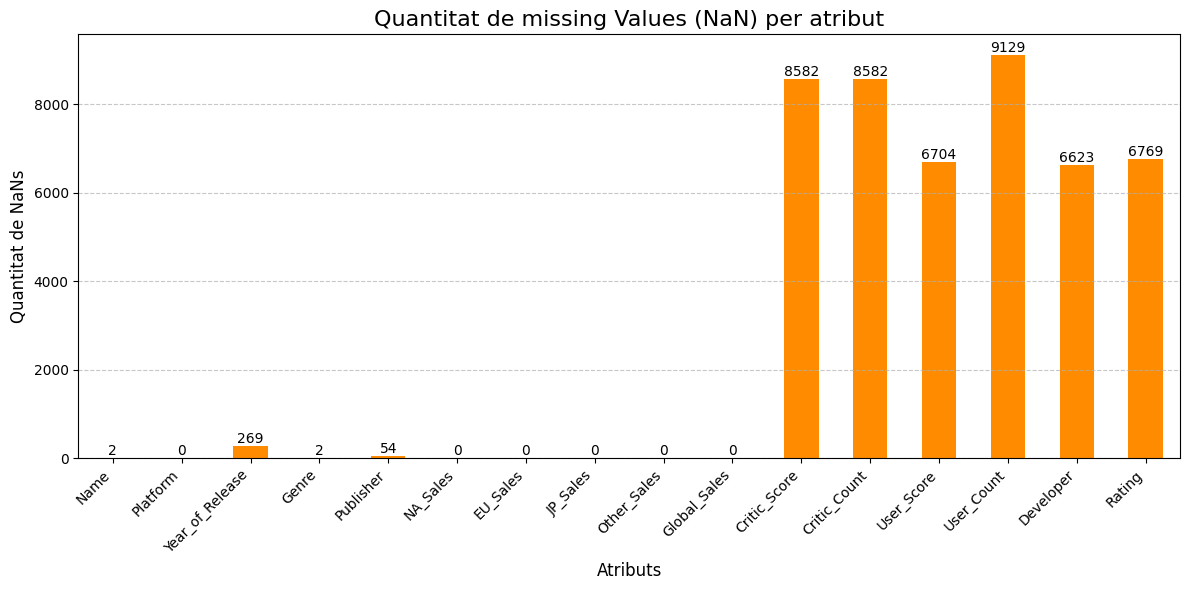

In [189]:
mostrarGraficNaNs(df)

Podem destacar que hi ha una gran quantitat de NaNs en les categories de valoracions (critic/user score i critic/user count), a més de la categoria Developer i rating. També podem veure una petita quantitat de NaNs en l'any de publicació i en el publisher del joc. Finalment, tant el gènere com el nom tenen un parell de NaNs.

Al haver una quantitat tant dràstica de NaNs en alguns dels atributs, en alguns casos rondant el 50%, no podem optar per eliminar les entrades que els contenen. Per tant, no ens queda més remei que omplir-los amb una estratègia d'imputació que ens permeti reduír el màxim possible el soroll que aquests generen.

---
## Preprocessament de dades

En aquesta part es dissenyarà i durà a terme un preprocessament de les dades. Aquest serà idèntic al que s'utilitzarà per al model final, de manera que podrem visualitzar millor els resultats d'aplicar cada pas d'aquest preprocessament. Tot i ser idèntic, el preprocessament del model es farà amb pipelines per tal d'aconseguir un resultat més robust i compacte.

Per començar el preprocessament definirem quins atributs del dataset son categòrics i quins són numèrics, utilitzant l'informació extreta de l'apartat anterior. Això ens permetrà fer un tratament més adequat de les dades i adaptar-les satisfactòriament per al model.

També descartarem altres atributs ja des d'un inici, els atributs de Name i Developer. Aquest primer ja que serveix com a identificador dels diferents jocs, però a no ser que es realitzi un tractament massa exhaustiu com el buscar paraules claus o sagues de jocs dins d'ells, no aportarà gran informació. L'atribut de developer es descartarà ja que comparteix molta informació amb el publisher, i no és tant important com aquest últim ja que no s'encarrega de la publicitat del joc. Addicionalment, com hem vist a l'apartat anterior, Developer compta amb molts NaNs que perjudicarien al model i generarien soroll.


In [190]:
#inicialitzacio de dades importants
numeric_features = ['Critic_Score', 'User_Score', 'Critic_Count', 'User_Count', 'Year_of_Release']
categorical_features = ['Platform','Rating','Publisher', 'Genre']

dfPrep = df

---
### Tractament de NaNs

Per una part, com hem vist a la part de visualització de dades, la columna "User_Score" es considerada categorica ja que conté dades "to be determined". Aquestes dades les tractarem com NaNs per poder tractarles mes endavant correctament amb la resta de missing values.

Una vegada tractats els "tbd" podem veure que la quantitat de valoracions de usuaris encaixa amb la quantitat de scores diferents.

De manera similar, farem el mateix amb els ratings. Com hem comentat abans, hem de convertir els 'RP' en NaNs i, ja que estem, els 'K-A' en 'E' per a adaptar-nos a l'etiquetatge ESRB.

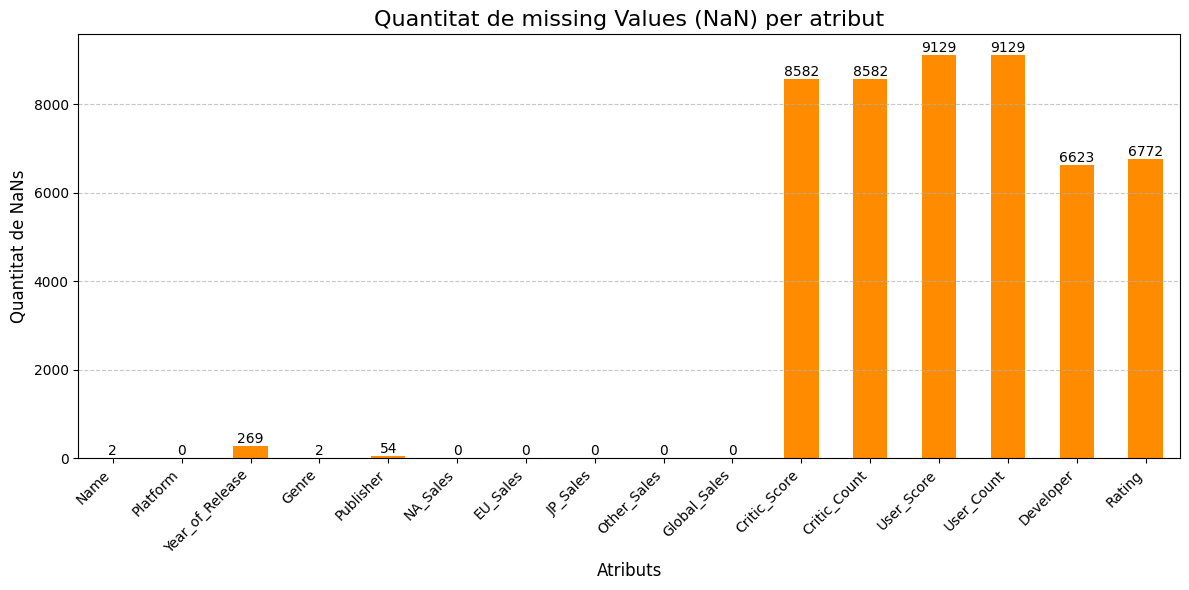

In [191]:
dfPrep['User_Score'] = dfPrep['User_Score'].replace('tbd', np.nan) #Transforma TBD en NaNs
dfPrep['User_Score'] = pd.to_numeric(dfPrep['User_Score']) #Converteix la columna en float
dfPrep['Rating'] = dfPrep['Rating'].replace('RP', np.nan) #Transforma RP en NaNs
dfPrep['Rating'] = dfPrep['Rating'].replace('K-A', 'E') #Transforma K-A en E
df_fixed = dfPrep
mostrarGraficNaNs(df_fixed)


Una vegada fet aixó, podem començar a procesar els NaNs. Hem decidit utilitzar un SimplerImputer, on per omplir els valors numerics utilitzarem  la mediana i per les categoriques utilitzarem la moda.



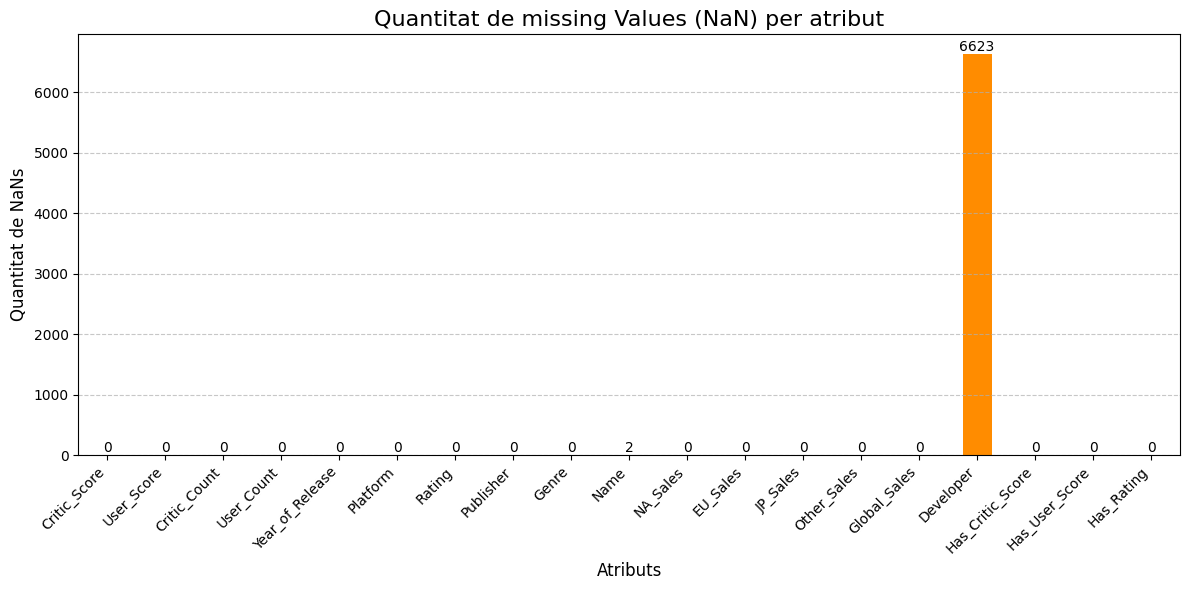

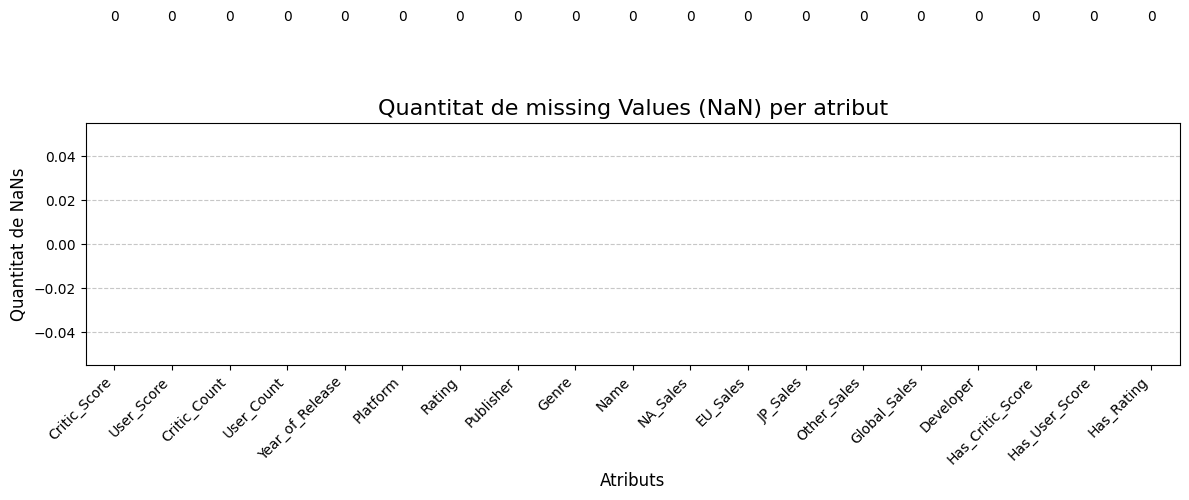

In [192]:
df_fixed['Has_Critic_Score'] = df_fixed['Critic_Score'].notnull().astype(int)
df_fixed['Has_User_Score'] = df_fixed['User_Score'].notnull().astype(int)
df_fixed['Has_Rating'] = df_fixed['Rating'].notnull().astype(int)

numeric_imputed = IterativeImputer(max_iter=10, random_state=42, min_value=0).fit_transform(df_fixed[numeric_features])
df_numeric = pd.DataFrame(numeric_imputed, columns=numeric_features, index=df.index)

categorical_imputed = SimpleImputer(strategy='most_frequent').fit_transform(df_fixed[categorical_features])
df_categorical = pd.DataFrame(categorical_imputed, columns=categorical_features, index=df.index)

passthrough_cols = [col for col in df_fixed.columns if col not in numeric_features + categorical_features]
df_passthrough = df_fixed[passthrough_cols]

df_imputed = pd.concat([df_numeric, df_categorical, df_passthrough], axis=1)

mostrarGraficNaNs(df_imputed)

df_imputed = df_imputed.dropna()

mostrarGraficNaNs(df_imputed)


---
### Data scaling

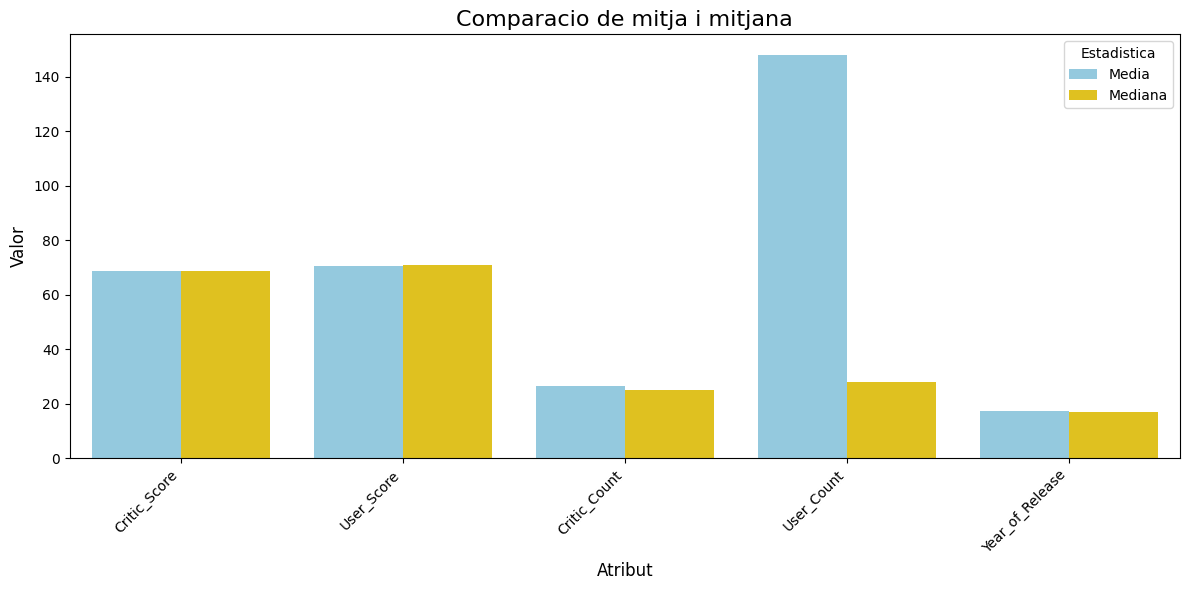

In [193]:
df_numeric_data = df_imputed[numeric_features]
df2 = df_imputed[numeric_features]
df2.loc[:, 'Year_of_Release'] = 2025 - df2['Year_of_Release']
df2.loc[:, 'User_Score'] = df2['User_Score'] * 10
atributos_numericos = numeric_features
# -----------------------------------------------------
medias = df2[numeric_features].mean().rename('Media')
medianas = df2[numeric_features].median().rename('Mediana')

df_stats = pd.concat([medias, medianas], axis=1)

df_plot = df_stats.reset_index().melt(
    id_vars='index',
    var_name='Estadística',
    value_name='Valor'
)

df_plot = df_plot.rename(columns={'index': 'Atributo'})

plt.figure(figsize=(12, 6))

sns.barplot(
    x='Atributo',
    y='Valor',
    hue='Estadística',
    data=df_plot,
    palette={'Media': 'skyblue', 'Mediana': 'gold'}
)
plt.title('Comparacio de mitja i mitjana', fontsize=16)
plt.xlabel('Atribut', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.legend(title='Estadistica')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


Per evitar el biaix de caracteristiques i millorar la convergencia mes endavant quan començem a entrenar els models, probarem diferents scalers. (explicar)

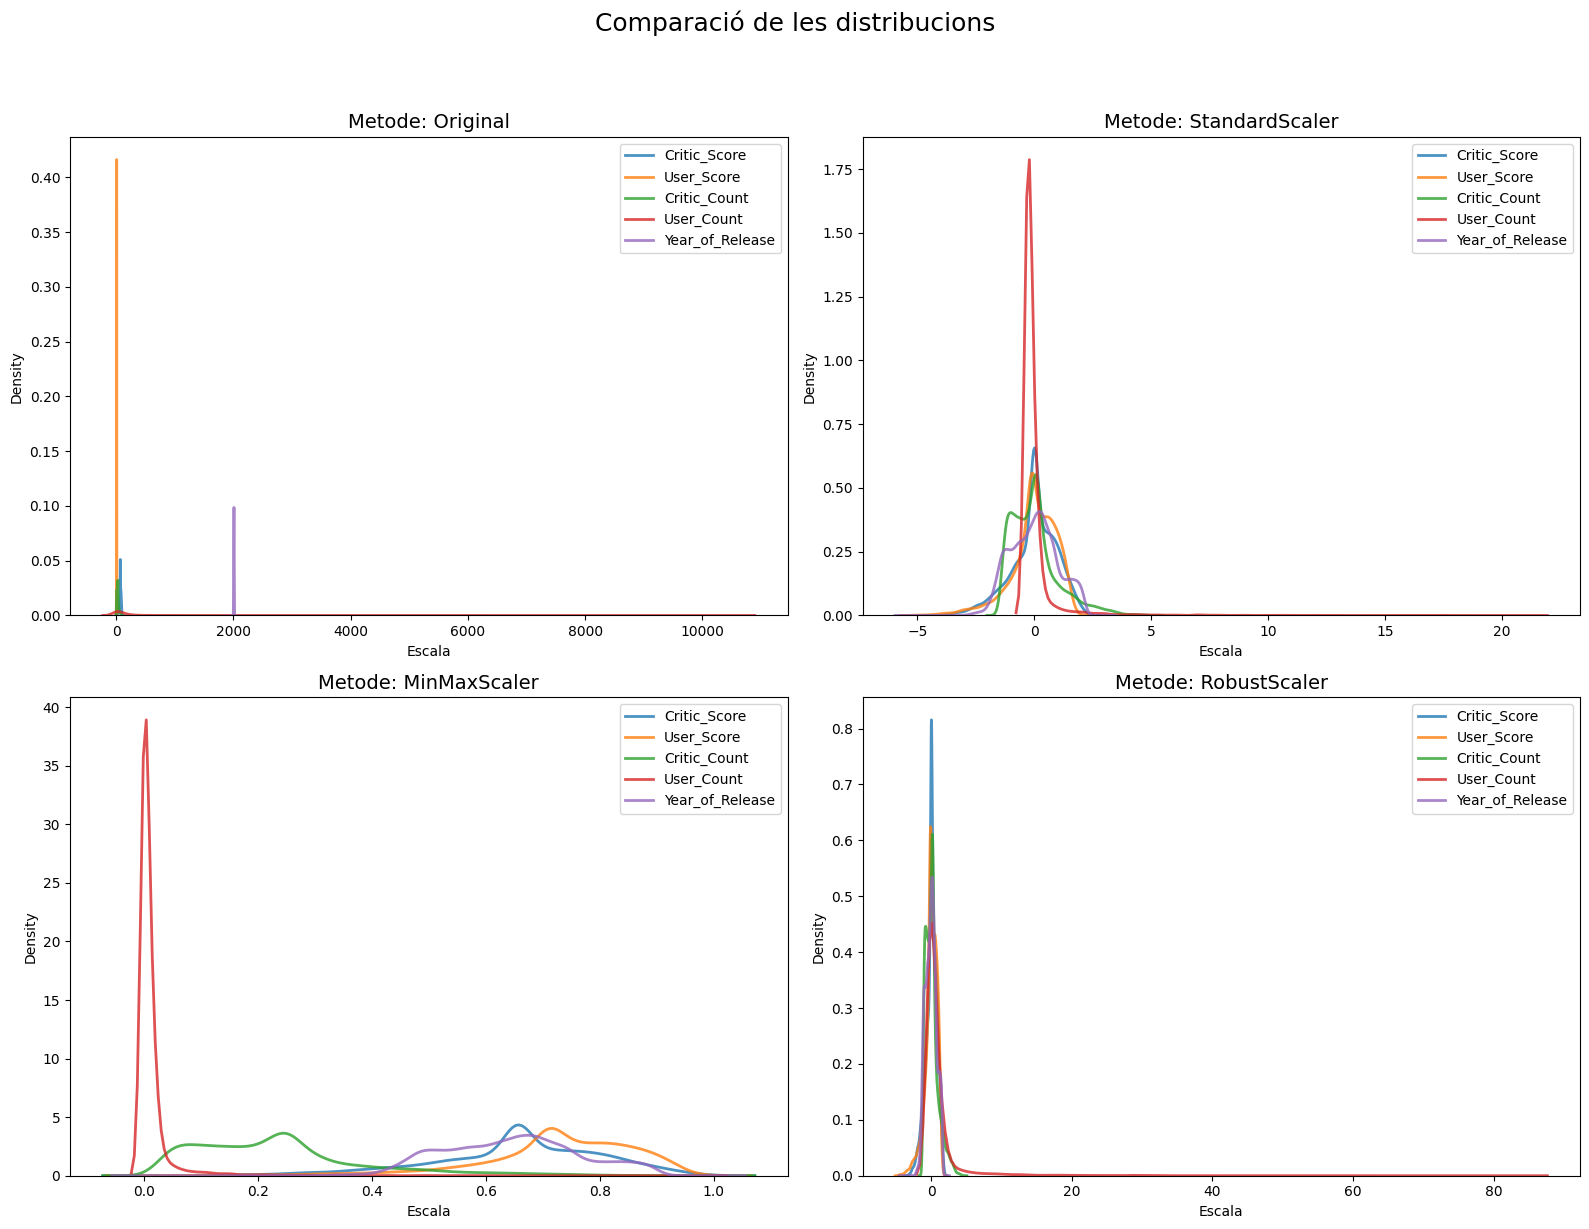

In [194]:
df_numeric_data = df_imputed[numeric_features]

scalers = {
    "Original": df_numeric_data.copy(),
    "StandardScaler": pd.DataFrame(StandardScaler().fit_transform(df_numeric_data), columns=numeric_features),
    "MinMaxScaler": pd.DataFrame(MinMaxScaler().fit_transform(df_numeric_data), columns=numeric_features),
    "RobustScaler": pd.DataFrame(RobustScaler().fit_transform(df_numeric_data), columns=numeric_features)}

plot_cols = ['Critic_Score', 'User_Score', 'Critic_Count', 'User_Count', 'Year_of_Release']

plt.figure(figsize=(16, 12))
plt.suptitle('Comparació de les distribucions', fontsize=18, y=1.02)

for i, (name, scaled) in enumerate(scalers.items(), 1):
    plt.subplot(2, 2, i)
    for col in plot_cols:
         sns.kdeplot(scaled[col], fill=False, label=col, alpha=0.8, linewidth=2)

    plt.title(f'Metode: {name}', fontsize=14)
    plt.xlabel('Escala')
    plt.legend()

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

df_scaled = df_imputed.copy()
df_scaled.update(scalers["RobustScaler"])



---
### Tractament de dades categóriques


Per altra banda, també hem de tractar els atributs categorics previament mencionats.

Si mirem la quantitat de valors unics per cada atribut (Platform, Rating, Developer, etc), podem veure que en developer y publisher hi ha una gran quantitat de valors unics. Codificar aquests amb un label/ordinal/onehot encoder pot donar problemes. Per solventar aixó, hem decidit tenir en compte els publishers. Amb aquests, els hem agrupat en 3 grups depenent del nombre de jocs que han publicat.
Per altra hem codificat el rating amb un ordinal encoder, de jocs per petits fins a nomes adults.
Per ultim, hem decidit aplicar onehot encoder al genere del joc.

In [195]:
columnas_categoricas = categorical_features

# 2. Iterar sobre las columnas y mostrar los valores únicos
for columna in columnas_categoricas:
    # Usamos .unique() para obtener la lista de valores únicos
    valores_unicos = df_scaled[columna].unique()

    # Imprimir el resultado
    print(f"\nAtribut: {columna}")
    print(f"Nombre de valors unics: {len(valores_unicos)}")
    # Se imprime solo una muestra para evitar listas muy largas
    print(f"Valors unics: {valores_unicos[:10]}")

    # Si la columna tiene muchos valores únicos, es mejor solo mostrar el conteo
    if len(valores_unicos) > 20:
        print(f"Hi ha mes de 20!")


Atribut: Platform
Nombre de valors unics: 17
Valors unics: ['Wii' 'DS' 'X360' 'PS3' 'PS2' '3DS' 'PS4' 'PS' 'XB' 'PC']

Atribut: Rating
Nombre de valors unics: 6
Valors unics: ['E' 'M' 'T' 'E10+' 'AO' 'EC']

Atribut: Publisher
Nombre de valors unics: 342
Valors unics: ['Nintendo' 'Microsoft Game Studios' 'Take-Two Interactive'
 'Sony Computer Entertainment' 'Activision' 'Ubisoft' 'Bethesda Softworks'
 'Electronic Arts' 'SquareSoft' '505 Games']
Hi ha mes de 20!

Atribut: Genre
Nombre de valors unics: 12
Valors unics: ['Sports' 'Racing' 'Platform' 'Misc' 'Action' 'Puzzle' 'Shooter'
 'Fighting' 'Simulation' 'Role-Playing']


In [196]:
publisher_counts = df_scaled.groupby('Publisher')['Name'].transform('count')

def classify_by_count(count):
    if count >= 1000:
        return 'Gegant'
    elif count >= 600:
        return 'Gran'
    elif count >= 300:
        return 'Mitja'
    elif count >= 50:
        return 'Petit'
    else:
        return 'Molt petit'

# 3. Aplicar la clasificación y crear la nueva característica segura
df_scaled['Publisher_Tier_Safe'] = publisher_counts.apply(classify_by_count)


# --- Resultados ---
print("Exemple de les primeres files:")
print(df_scaled[['Publisher', 'Publisher_Tier_Safe']].head(5))
print("\nQuantitat de Publishers per Tier:")
print(df_scaled['Publisher_Tier_Safe'].value_counts())
print("-" * 60)

Exemple de les primeres files:
  Publisher Publisher_Tier_Safe
0  Nintendo               Mitja
2  Nintendo               Mitja
3  Nintendo               Mitja
6  Nintendo               Mitja
7  Nintendo               Mitja

Quantitat de Publishers per Tier:
Publisher_Tier_Safe
Petit         2852
Mitja         2617
Molt petit    1909
Gran          1569
Gegant        1149
Name: count, dtype: int64
------------------------------------------------------------


In [197]:
#ORDINAL ENCODER
rating_categories = [['EC', 'E', 'E10+', 'T', 'M', 'AO']]

ordinal_encoder = OrdinalEncoder(categories=rating_categories)
rating_column = df_scaled[['Rating']]
rating_encoded_array = ordinal_encoder.fit_transform(rating_column)
df_scaled['Rating'] = rating_encoded_array.flatten()

#ONEHOT ENCODER
cols_to_encode = ['Genre', 'Platform']
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_array = onehot_encoder.fit_transform(df_scaled[cols_to_encode])
new_cols = onehot_encoder.get_feature_names_out(cols_to_encode)
df_encoded = pd.DataFrame(
    encoded_array,
    columns=new_cols,
    index=df_scaled.index
)
df_scaled = pd.concat([df_scaled.drop(cols_to_encode, axis=1), df_encoded], axis=1)

print(df_scaled.columns)


Index(['Critic_Score', 'User_Score', 'Critic_Count', 'User_Count',
       'Year_of_Release', 'Rating', 'Publisher', 'Name', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Developer',
       'Has_Critic_Score', 'Has_User_Score', 'Has_Rating',
       'Publisher_Tier_Safe', 'Genre_Action', 'Genre_Adventure',
       'Genre_Fighting', 'Genre_Misc', 'Genre_Platform', 'Genre_Puzzle',
       'Genre_Racing', 'Genre_Role-Playing', 'Genre_Shooter',
       'Genre_Simulation', 'Genre_Sports', 'Genre_Strategy', 'Platform_3DS',
       'Platform_DC', 'Platform_DS', 'Platform_GBA', 'Platform_GC',
       'Platform_PC', 'Platform_PS', 'Platform_PS2', 'Platform_PS3',
       'Platform_PS4', 'Platform_PSP', 'Platform_PSV', 'Platform_Wii',
       'Platform_WiiU', 'Platform_X360', 'Platform_XB', 'Platform_XOne'],
      dtype='object')


In [198]:
df_scaled = df_scaled.drop(columns=['Name', 'Developer', 'Publisher'])

print('Visualització del dataset:')
print(df_scaled)
print('--------------------------------------------------------------------------\n')
print("Nombre d'atributs:", len(df.columns))
print('Descripció dels atributs: ')
print(df_scaled.describe(include='all'))
print('--------------------------------------------------------------------------\n')
print('Informació sobre els NaNs dels atributs: ')
print(df_scaled.info())

Visualització del dataset:
       Critic_Score  User_Score  Critic_Count  User_Count  Year_of_Release  \
0          0.452452    0.599951      1.368421    2.370968        -0.369022   
2          0.702923    0.599951      2.526316    1.322581         0.184511   
3          1.266481    0.933284      2.105263    3.250000        -0.369022   
6          1.391717    0.999951      2.052632    3.516129        -0.553533   
7          0.702923    0.399951      2.000000    0.951613        -0.184511   
...             ...         ...           ...         ...              ...   
16702     48.000000    5.605085     10.000000    0.000000      2008.000000   
16706     60.000000    7.200000     12.000000   13.000000      2011.000000   
16708     68.660871    7.014536     26.811906  145.764478      2008.000000   
16709     63.000000    5.800000      6.000000    8.000000      2009.000000   
16710     68.471718    7.442224     21.637124   18.725535      2003.000000   

       Rating  NA_Sales  EU_Sales  J

---
## Selecció de mètriques
Una vegada preprocesades les dades, seleccionem la millor mètrica pel problema

MSE, RMSE,R^2

Errores grandes son catastróficos,RMSE,Penaliza fuertemente los outliers o grandes desviaciones debido al término cuadrático.

Todos los errores son iguales,MAE,Trata todas las desviaciones por igual; es la más fácil de explicar a personas sin conocimientos técnicos.

Necesitas un resumen del ajuste,R2,Te da el contexto de qué tan útil es tu modelo en comparación con un modelo base simple (la media).

---
## Selecció del model
Una vegada seleccionada la millor mètrica, seleccionarem el millor model pel problema

In [199]:
#Funcions utils adaptades a l'api de sklearn, ja q els utilitzem en el pipelining

numeric_features = ['Critic_Score', 'User_Score', 'Critic_Count', 'User_Count', 'Year_of_Release']
rating_feature = ['Rating']
binary_features = ['Has_Critic_Score', 'Has_User_Score', 'Has_Rating']
rating_categories = [['EC', 'E', 'E10+', 'T', 'M', 'AO']]
genre_platform_features = ['Genre', 'Platform']
publisher_feature = ['Publisher_Tier']
tier_categories = [['Molt petit', 'Petit', 'Mitja', 'Gran', 'Gegant']]

class UserScoreCleaner(BaseEstimator, TransformerMixin): #canvia esl tbd per nans a la columna user score i o pasa a float
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['User_Score'] = X['User_Score'].replace('tbd', np.nan) #Transforma TBD en NaNs
        X['User_Score'] = pd.to_numeric(X['User_Score']) #Converteix la columna en float
        X['Rating'] = X['Rating'].replace('RP', np.nan) #Transforma RP en NaNs
        X['Rating'] = X['Rating'].replace('K-A', 'E') #Transforma K-A en E

        X['Has_Critic_Score'] = X['Critic_Score'].notnull().astype(int)
        X['Has_User_Score'] = X['User_Score'].notnull().astype(int)
        X['Has_Rating'] = X['Rating'].notnull().astype(int)
        return X

class PublisherBinner(BaseEstimator, TransformerMixin): #codifica els publishers
    def fit(self, X, y=None):
        self.publisher_counts_ = X['Publisher'].value_counts()
        return self

    def transform(self, X):
        X = X.copy()

        def classify(publisher):
            count = self.publisher_counts_.get(publisher, 0)
            if count >= 1000:
              return 'Gegant'
            elif count >= 600:
              return 'Gran'
            elif count >= 300:
              return 'Mitja'
            elif count >= 50:
              return 'Petit'
            else:
              return 'Molt petit'

        X['Publisher_Tier'] = X['Publisher'].apply(classify)
        X.loc[:, 'Year_of_Release'] = 2025 - X['Year_of_Release']
        X.loc[:, 'User_Score'] = X['User_Score'] * 10
        cols_to_drop = [c for c in ['Name', 'Developer', 'Publisher'] if c in X.columns]
        X = X.drop(columns=cols_to_drop)
        return X


In [200]:
def construir_preprocesador():
    """Define y ensambla todos los pasos de preprocesamiento en un solo Pipeline."""

    # 1. Numérico: Imputar media + Indicador de Faltantes -> RobustScaler
    numeric_transformer = Pipeline(steps=[
        ('imputer', IterativeImputer(max_iter=10, random_state=42, min_value=0)),
        ('scaler', RobustScaler())
    ])

    # 2. Rating: Imputar moda -> OrdinalEncoder
    rating_transformer = Pipeline(steps=[
        ('encoder', OrdinalEncoder(categories=rating_categories, handle_unknown='use_encoded_value', unknown_value=-1)),
        ('imputer', IterativeImputer(max_iter=10, random_state=42, min_value=0)),
    ])

    # 3. Genre: Imputar moda -> OneHotEncoder
    genre_platform_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # 4. Publisher Tier: Imputar moda -> OrdinalEncoder
    publisher_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder(categories=tier_categories))
    ])

    # --- Unir todo en el ColumnTransformer ---
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('rating', rating_transformer, rating_feature),
            ('genre_platform', genre_platform_transformer, genre_platform_features),
            ('tier', publisher_transformer, publisher_feature),
            ('flags', 'passthrough', binary_features)
        ],
        remainder='drop'
    )

    # --- Pipeline de Preprocesamiento Final ---
    full_preprocessor_pipeline = Pipeline(steps=[
        ('cleaner', UserScoreCleaner()),
        ('binner', PublisherBinner()),
        ('preprocessor', preprocessor)
    ])

    return full_preprocessor_pipeline

In [201]:
def entrenar_modelos_no_lineales(df, target_col):
    """
    Ejecuta GridSearchCV para modelos de regresión NO lineales (SVR y XGBoost)
    y genera gráficos de evaluación.
    """
    print(f"--- Iniciando GridSearch (XGBOOST) para: {target_col} ---")

    # 1. Preparar datos
    sales_cols = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']
    X = df.drop(columns=sales_cols)
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 2. Obtener el Preprocesador Completo (Asumido)
    # Se asume que 'construir_preprocesador()' gestiona las transformaciones de las características
    preprocessor_pipeline = construir_preprocesador()

    # 3. Seleccionar Modelo y Parámetros

    xgb = XGBRegressor(
        random_state=42,
        n_jobs=-1,
        objective='reg:squarederror' # El objetivo estándar funciona bien con datos logarítmicos
    )

    # 4. Envolver el XGBoost con TransformedTargetRegressor
    # Esto se encarga del log1p antes de entrenar y expm1 después de predecir
    model_wrapper = TransformedTargetRegressor(
        regressor=xgb,
        func=np.log1p,       # Transformación: log(1 + x)
        inverse_func=np.expm1 # Inversa: exp(x) - 1
    )

    # 5. Pipeline Final
    # Nota: El wrapper va al final del pipeline
    full_pipeline = Pipeline(steps=[
        ('preproc', preprocessor_pipeline),
        ('model', model_wrapper)
    ])

    param_grid = {
        'model__regressor__n_estimators': [100, 200, 300, 500],
        'model__regressor__learning_rate': [0.01, 0.05, 0.1],
        'model__regressor__max_depth': [3, 4, 5, 7],
        'model__regressor__subsample': [0.7, 0.9],
        'model__regressor__colsample_bytree': [0.7, 0.9],
        'model__regressor__gamma': [0.1, 0.2, 0.5, 1, 5, 10],
        'model__regressor__min_child_weight': [3, 5, 10, 20, 50]
    }


    # 5. Configurar y Ejecutar GridSearchCV
    grid_search = RandomizedSearchCV(
        estimator=full_pipeline,
        param_distributions=param_grid,
        n_iter=30,
        cv=3,
        scoring='neg_mean_absolute_error',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )

    print(f"Ejecutando GridSearch para XGBOOST...")
    grid_search.fit(X_train, y_train)

    # 6. Resultados (Métricas)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    test_mae = mean_absolute_error(y_test, y_pred)
    test_mse = mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)

    # 7. Evaluación Final (Impresión de resultados)
    print(f"\nMejores parámetros encontrados: {grid_search.best_params_}")
    print(f"Mejor MSE en Validación Cruzada: {abs(grid_search.best_score_):.4f}")
    print(f"MAE test: {test_mae:.4f}")
    print(f"MSE test: {test_mse:.4f}")
    print(f"R2 test: {test_r2:.4f}")

    # --- 8. GENERACIÓN DE GRÁFICOS SEABORN ---

    # Creamos un DataFrame para graficar
    results_df = pd.DataFrame({
        'Real': y_test,
        'Predicho': y_pred,
        'Residuo': y_test - y_pred # Residuo = Real - Predicho
    })

    plt.figure(figsize=(20, 6))

    # --- Gráfico 1: Valores Reales vs. Predichos escala completa ---
    plt.subplot(1, 3, 1) # 1 fila, 3 columnas, posición 1
    sns.scatterplot(x='Real', y='Predicho', data=results_df, alpha=0.4)

    # Línea perfecta de predicción (donde Real = Predicho)
    max_val = results_df[['Real', 'Predicho']].max().max()
    plt.plot([0, max_val], [0, max_val], 'r--', lw=2)

    plt.title(f'Escala completa: Real vs Predicho', fontsize=12)
    plt.xlabel('Real Sales')
    plt.ylabel('Predicted Sales')
    plt.grid(True, alpha=0.3)

    # --- Gráfico 2: Valores Reales vs. Predichos zoom ---
    plt.subplot(1, 3, 2)
    sns.scatterplot(x='Real', y='Predicho', data=results_df, alpha=0.4, color='g')

    plt.plot([0, 5], [0, 5], 'r--', lw=2)

    # ZOOM
    plt.xlim(0, 5)
    plt.ylim(0, 5)

    plt.title(f'Zoom: Real vs Predicho', fontsize=12)
    plt.xlabel('Real Sales')
    plt.ylabel('Predicted Sales')
    plt.grid(True, alpha=0.3)

    # --- Gráfico 3: Distribución de Residuos ---
    plt.subplot(1, 3, 3) # 1 fila, 2 columnas, posición 2
    sns.histplot(results_df['Residuo'], bins=30, kde=True, color='skyblue')

    # Línea en Residuo = 0
    plt.axvline(x=0, color='red', linestyle='--')

    plt.title(f'Distribución de Residuos | XGBOOST', fontsize=14)
    plt.xlabel('Residuo (Error)', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)

    plt.tight_layout() # Ajusta el layout para que no se superpongan
    plt.show() # Muestra los dos gráficos

    return best_model

Resultats per: Global_Sales
--- Iniciando GridSearch (XGBOOST) para: Global_Sales ---
Ejecutando GridSearch para XGBOOST...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Mejores parámetros encontrados: {'model__regressor__subsample': 0.9, 'model__regressor__n_estimators': 200, 'model__regressor__min_child_weight': 5, 'model__regressor__max_depth': 7, 'model__regressor__learning_rate': 0.05, 'model__regressor__gamma': 0.1, 'model__regressor__colsample_bytree': 0.9}
Mejor MSE en Validación Cruzada: 0.3577
MAE test: 0.3815
MSE test: 3.3374
R2 test: 0.1915


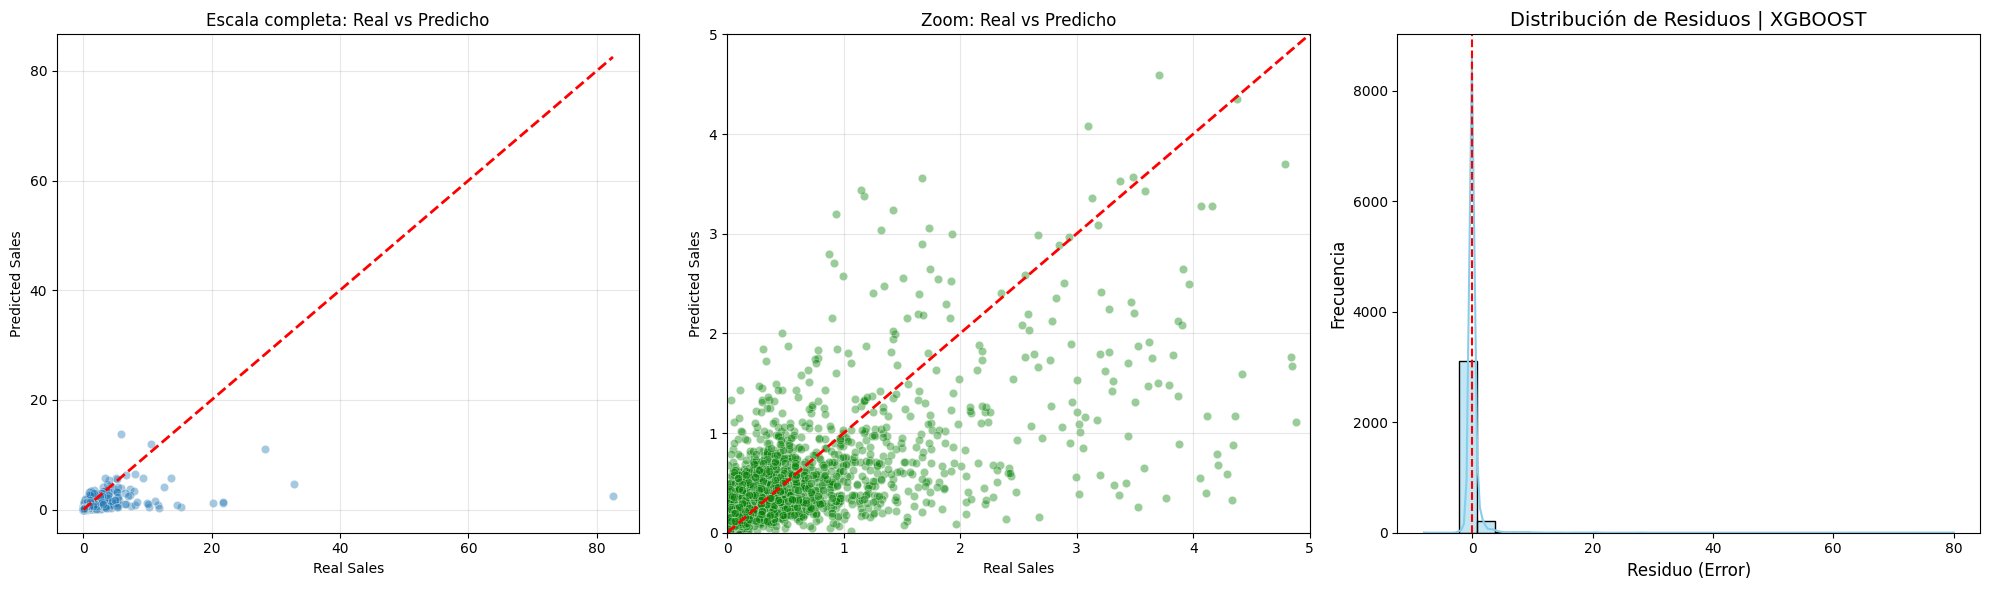

Resultats per: NA_Sales
--- Iniciando GridSearch (XGBOOST) para: NA_Sales ---
Ejecutando GridSearch para XGBOOST...
Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [ ]:
targets = ['Global_Sales','NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

for t in targets:
  print("Resultats per: " + t)
  model_xgboost = entrenar_modelos_no_lineales(df, target_col=t)

---
## Anàlisis final
Inicialmente hemos notado que los modelos no lineales (svr, xgboost) dan resultados bastante más acertados que los lineales. En cuanto a estos primeros, la svg da peores resultados que el xgboost, tardando un tiempo de entrenamiento mucho mayor. Aún así, los valores de R2 y el error siguen estando por debajo de lo esperado.

Todo esto se puede explicar entendiendo mejor los datos con los que estamos tratando. Las ventas de los juegos no se distribuyen de forma lineal, si no que hay pocos que venden millones y muchos que venden poco. Esto encaja mejor con un crecimiento logarítmico.

Para hacer que los modelos se adapten mejor a este crecimiento, vamos a tratar los datos de forma logarítmica. Vamos a dividir el proyecto en 2 ramas, modelos lineales y no lineales.
Para los modelos lineales, vamos a intentar calcular el logaritmo de las ventas en lugar de las própias ventas. Esto debería mejorar mucho su rendimiento. También cambiaremos ridge y lasso por elasticnet, que se adapta mejor a los polinomios. Aún así, somos conscientes de sus limitaciones y de que seguramente darán peores resultados que los no lineales.
En cuanto a los no lineales, vamos a eliminar la svm e intentar que la xgboost sea lo más precisa posible. Cambiaremos su función para que se adapte al comportamiento polinómico de los datos y aprenda más lentamente pero de forma más sólida. También modificaremos un poco el preprocesamiento para maximizar la información que recibe el modelo, ya que al no usar svm ya no hará falta simplificarlo tanto.